# Code for writing the lung sound data to .ts file

Below is the code for writing the tromsø dataset to .ts files

In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from scipy.stats import skew 

sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis

from time import time
import sys
import os
figure_path = module_path + '/figures/'

sys.path.insert(1, module_path + '/src/')

from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 8000

import os
names = []
files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
names_full = os.listdir(files_path)
for n in names_full:
    if '_lungelyd_' in n:
        names.append(n)
        
X = pd.read_stata('/home/andrine/Desktop/dataTromso/hasse_413_ut.dta')
X_no_nan = X.dropna(thresh=1, axis=1)

cols = []

for col in X_no_nan:
    if np.any(X_no_nan[col] != ''):
        cols.append(col)
    else:
        continue 
        
X_no_nan = X_no_nan[cols]

del X
del names_full
del cols

Defining some helping functions, that will be important when extracting 

In [7]:
map_wav = {
    '1': 'a',
    '2': 'b',
    '3': 'c',
    '4': 'd',
    '5': 'e',
    '6': 'f'
}

abnormalities = ['insp_wheeze', 'exp_wheeze', 'insp_crackle', 'exp_crackle']


dq_params = {
    'q1': 4,
    'redundancy_1': 5,
    'stages_1': 15,
    'q2': 1,
    'redundancy_2': 5,
    'stages_2': 15,
    'lambda_1': 0.4,
    'lambda_2': 0.4,
    'mu': 0.1,
    'num_iterations': 100,
    'compute_cost_function': True
}

def get_precence_columns(label, wav):
    map_wav = {
        '1': 'a',
        '2': 'b',
        '3': 'c',
        '4': 'd',
        '5': 'e',
        '6': 'f'
    }
    
    i = map_wav[wav]
    
    
    multiple_present = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_number_insp_t72', f'sub_{i}_ob1_i_wh_number_insp_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_number_exp_t72', f'sub_{i}_ob1_e_wh_number_exp_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_number_insp_t72', f'sub_{i}_ob1_i_cr_number_insp_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_number_exp_t72', f'sub_{i}_ob1_e_cr_number_exp_t72']}
    if label not in multiple_present.keys():
        return None
    return multiple_present[label]



def get_column_observer_wav_file(observer, wav):    
    i = map_wav[wav]
    classify_dict = {
        'a' : [f'lung{i}_abnormal_sound_a_t72',
        f'lung{i}_insp_wheeze_a_t72',
        f'lung{i}_exp_wheeze_a_t72',
        f'lung{i}_insp_crackle_a_t72',
        f'lung{i}_exp_crackle_a_t72',
        f'lung{i}_other_abnorm_sound_a_t72',
        f'lung{i}_not_classifiable_a_t72'],

        'b' :  [f'lung{i}_abnormal_sound_b_t72',
        f'lung{i}_insp_wheeze_b_t72',
        f'lung{i}_exp_wheeze_b_t72',
        f'lung{i}_insp_crackle_b_t72',
        f'lung{i}_exp_crackle_b_t72',
        f'lung{i}_other_abnorm_sound_b_t72',
        f'lung{i}_not_classifiable_b_t72'],


        'c' : [f'lung{i}_abnormal_sound_c_t72',
        f'lung{i}_insp_wheeze_c_t72',
        f'lung{i}_exp_wheeze_c_t72',
        f'lung{i}_insp_crackle_c_t72',
        f'lung{i}_exp_crackle_c_t72',
        f'lung{i}_other_abnorm_sound_c_t72',
        f'lung{i}_not_classifiable_c_t72']
    }
    
    return classify_dict[observer]

def get_second_round_eval(X, idx, label, wav):
    if label not in abnormalities: # Return True if there is no abnormality present
        return True
    i = map_wav[wav]
    
    second_round_res = {
        0 : 'not evaluated',
        1 : 'present',
        2 : 'absent', 
        3 : 'uncertain'
    }

    second_round_pres =  {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_presence_t72', f'sub_{i}_ob1_i_wh_presence_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_presence_t72', f'sub_{i}_ob1_e_wh_presence_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_presence_t72', f'sub_{i}_ob1_i_cr_presence_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_presence_t72', f'sub_{i}_ob1_e_cr_presence_t72']}

    round2 = X.iloc[idx][second_round_pres[label]].values[0].astype(int)
    
    if (round2[0] == 2) or (round2[1] == 2): # Return False if second round of observers concluded absent 
        return False
    else:
        return True
    '''
    if  (round2[0] < 0) or (round2[1] < 0):
        print(X.iloc[idx][second_round_pres[label]].values[0])
        return ''
    elif (round2[0] == round2[1]):
        return second_round_res[round2[0]] # agreement
    
    
    return second_round_res[round2[0]] + ' ' + second_round_res[round2[1]]
    '''
    
    
def get_sub_audios(audio, frac):
    base = len(audio)//frac
    half_base = base //2
    lengths = [(0, base)]

    while lengths[-1][1] < len(audio):
        lengths.append((lengths[-1][0] + base - half_base, lengths[-1][1] + base - half_base))

    sub_audio = []
    prev_len = len(audio[lengths[0][0]:lengths[0][1]])

    for l in lengths:
        sub = audio[l[0]:l[1]]
        if prev_len != len(sub):
            diff = prev_len - len(sub)
            sub = audio[l[0]- diff:l[1]]
            #print(diff)
        prev_len = len(sub)
        #print(len(sub))
        sub_audio.append(sub)
    return sub_audio



def perform_decomposition(data):
    dq = DualQDecomposition(**dq_params)
    high_res, low_res = dq(data)
    residual = data - high_res - low_res
    return low_res, high_res, residual

def get_entropy(audio):
    audio_nz = audio[audio != 0]
    return - np.sum(((audio_nz**2)*np.log(audio_nz**2)))
    
def get_energy(audio):  
    N = len(audio)
    return np.sum(np.abs(audio) ** 2) / N

def get_wavelet_features(data):
    ft0 = np.hstack((np.mean(data), np.std(data),
                           skew(data), np.max(data),
                           kurtosis(data), np.min(data),
                           get_energy(data), get_entropy(data)))
    #return pd.Series(ft0).to_frame().T 
    return list(ft0)

def get_xf(y, sr):
    duration = float(len(y)) / sr
    T = 1.0/sr
    N = int(duration / T)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    return xf

def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))


def get_resonance_features(data, sr):
    low_cut = 120
    high_cut = 1800

    data = butter_bandpass_filter(data, low_cut, high_cut, sr, order=12)
    
    
    if data.shape[0]%2:
        data = data[0:-1]
    
    
    low_res, high_res , res = perform_decomposition(data)
    _, _, Zxx_low = stft(low_res, sr, nperseg=256, window = 'hamming', noverlap=204) # 204 is 80% overlap
    _, _, Zxx_high  = stft(high_res, sr, nperseg=256, window = 'hamming', noverlap=204) # 204 is 80% overlap
    _, _, Zxx_res = stft(res, sr, nperseg=256, window = 'hamming', noverlap=204) # 204 is 80% overlap

    low_ = abs(np.sum(Zxx_low, axis = 1))
    high_ = abs(np.sum(Zxx_high, axis = 1))
    res_ = abs( np.sum(Zxx_res, axis = 1))
    
    
    row = np.hstack([list(low_),list(high_),list(res_)])
    
    row = pd.Series(np.hstack([row, get_wavelet_features(low_res), get_wavelet_features(high_res), get_wavelet_features(res)]))
    return row


def get_filename_label_map():
    annotation_list = ['abnormal_sound', 'insp_wheeze',
                       'exp_wheeze', 'insp_crackle', 'exp_crackle',
                      'other', 'not_classifiable']

    count = 0
    error_in_data = {}
    data = pd.DataFrame({'id':[] , 'nr': [],'label':[]})
    for n in names:
        i = n[0:8]
        try:
            wav = n.split('.')[0][-1]
        except IndexError as error:
            print(n)
            continue
        row_nr = np.where(X_no_nan['unikt_lopenr'] == i)[0] 
        a_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('a', wav)].values[0]
        b_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('b', wav)].values[0]

        if np.any(a_obs != b_obs):  # Check that observer a and observer b agree
            c_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('c', wav)].values[0]
        else:
            c_obs = a_obs


        if (c_obs[0] == 0) or (np.isnan(c_obs[0])):
            label = 'normal'
        else:
            try:
                label_idx = np.where(c_obs == 1.)[0]
                label = annotation_list[label_idx[1]]
                if len(label_idx) > 2: # Do not include samples with more than type of abnormality
                    error_in_data[n] = 'more than one abnormality'
                    count = count + 1
                    continue
            except IndexError as error:
                error_in_data[n] = 'IndexError'

        if not get_second_round_eval(X_no_nan, row_nr, label, wav): # If the second round of observers have concluded absent
            count = count + 1
            continue
            
        cols = get_precence_columns(label, wav)
        
        if cols != None: # Filtering to be sure that there appears more than one abnormality during the 15 s
            votes = X_no_nan.iloc[row_nr][cols].values[0]
            votes = votes[0] + votes[1]
            if votes < 3: 
                count = count + 1
                continue
                
                
        audio_file = files_path + n        
        data = data.append(pd.DataFrame({'id': [audio_file],'nr': [i] ,'label': [label]}))
        
        
        #if count == 100:
        #    break
    return error_in_data , data, count

def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new


lowcut = 150
highcut = 1950
FRAME_RATE = 5000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=6)

Obtaining the data correlated with filepath, label and ID

In [3]:
start = time()

error, data, count = get_filename_label_map()

total = time() - start
print(f'Time utilized: {total} ')

.15916931_lungelyd_5.wav.f4Tk8a
Time utilized: 46.76050877571106 


Cutting the dataset down to 3 classes, and balancing the dataset

In [4]:
indices_1 = np.where(data['label'] == 'normal')[0]
indices_2 = np.where(data['label'] == 'exp_wheeze')[0]
indices_3 = np.where(data['label'] == 'insp_crackle')[0]
indices_4 = np.where(data['label'] == 'insp_wheeze')[0]
indices_5 = np.where(data['label'] == 'exp_crackle')[0]
indices_6 = np.where(data['label'] == 'other')[0]
indices_7 = np.where(data['label'] == 'not_classifiable')[0]

np.random.seed(0)
np.random.shuffle(indices_1)
indices = np.concatenate((indices_1[0:400], indices_2, indices_3, indices_4, indices_5))

new_dataset = data.iloc[indices].copy()
del data

#new_dataset.loc[new_dataset['label'] == 'exp_crackle' , 'label'] = 'crackle'
#new_dataset.loc[new_dataset['label'] == 'insp_crackle' , 'label'] = 'crackle'

#new_dataset.loc[new_dataset['label'] == 'exp_wheeze' , 'label'] = 'wheeze'
#new_dataset.loc[new_dataset['label'] == 'insp_wheeze' , 'label'] = 'wheeze'

In [5]:
new_dataset['label'].value_counts()

normal          400
insp_crackle    305
exp_wheeze      268
insp_wheeze      33
exp_crackle      28
Name: label, dtype: int64

## Writing the data to a ts file 

In [9]:
from sklearn.model_selection import train_test_split

new_dataset.sort_values(by=['nr'], inplace=True)


id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

new_dataset.reset_index(drop = False)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        #print(list(idx))
        #indices.append(list(idx))
        indices = np.append([list(idx)] , [indices])
        
    return indices

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

In [13]:
file_splits = {
    '/features/extracted_ts_files/UiT_allLabels_15s_TRAIN.ts' : indices_train,
    '/features/extracted_ts_files/UiT_allLabels_15s_TEST.ts' : indices_test,
    '/features/extracted_ts_files/UiT_allLabels_15s_VAL.ts' : indices_val
    
}


def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal exp_crackle exp_wheeze insp_crackle insp_wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 4000), 4000
            '''
            sub_audio = get_sub_audios(audio, frac)
            for sub in sub_audio: 
                #sub = znorm(sub)
                #sub = get_resonance_features(sub, sr)
                sub = get_features(sub, sr)
                new_row = str(list(sub))[1:-1].replace(' ', '') + ':' + label + '\n'
                w.write(new_row)
            '''
            audio = get_features(audio, sr)
            new_row = str(list(audio))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)
            count = count + 1
            print(f'Extracting file : {count}, of totally {len(data)}')    
            
            #break
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
            
'''
frac = 3 --> 5 seconds
frac = 5 --> 3 seconds

'''            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i],5)

Extracting file : 1, of totally 826
Extracting file : 2, of totally 826
Extracting file : 3, of totally 826
Extracting file : 4, of totally 826
Extracting file : 5, of totally 826
Extracting file : 6, of totally 826
Extracting file : 7, of totally 826
Extracting file : 8, of totally 826
Extracting file : 9, of totally 826
Extracting file : 10, of totally 826
Extracting file : 11, of totally 826
Extracting file : 12, of totally 826
Extracting file : 13, of totally 826
Extracting file : 14, of totally 826
Extracting file : 15, of totally 826
Extracting file : 16, of totally 826
Extracting file : 17, of totally 826
Extracting file : 18, of totally 826
Extracting file : 19, of totally 826
Extracting file : 20, of totally 826
Extracting file : 21, of totally 826
Extracting file : 22, of totally 826
Extracting file : 23, of totally 826
Extracting file : 24, of totally 826
Extracting file : 25, of totally 826
Extracting file : 26, of totally 826
Extracting file : 27, of totally 826
Extracting

Extracting file : 221, of totally 826
Extracting file : 222, of totally 826
Extracting file : 223, of totally 826
Extracting file : 224, of totally 826
Extracting file : 225, of totally 826
Extracting file : 226, of totally 826
Extracting file : 227, of totally 826
Extracting file : 228, of totally 826
Extracting file : 229, of totally 826
Extracting file : 230, of totally 826
Extracting file : 231, of totally 826
Extracting file : 232, of totally 826
Extracting file : 233, of totally 826
Extracting file : 234, of totally 826
Extracting file : 235, of totally 826
Extracting file : 236, of totally 826
Extracting file : 237, of totally 826
Extracting file : 238, of totally 826
Extracting file : 239, of totally 826
Extracting file : 240, of totally 826
Extracting file : 241, of totally 826
Extracting file : 242, of totally 826
Extracting file : 243, of totally 826
Extracting file : 244, of totally 826
Extracting file : 245, of totally 826
Extracting file : 246, of totally 826
Extracting f

Extracting file : 437, of totally 826
Extracting file : 438, of totally 826
Extracting file : 439, of totally 826
Extracting file : 440, of totally 826
Extracting file : 441, of totally 826
Extracting file : 442, of totally 826
Extracting file : 443, of totally 826
Extracting file : 444, of totally 826
Extracting file : 445, of totally 826
Extracting file : 446, of totally 826
Extracting file : 447, of totally 826
Extracting file : 448, of totally 826
Extracting file : 449, of totally 826
Extracting file : 450, of totally 826
Extracting file : 451, of totally 826
Extracting file : 452, of totally 826
Extracting file : 453, of totally 826
Extracting file : 454, of totally 826
Extracting file : 455, of totally 826
Extracting file : 456, of totally 826
Extracting file : 457, of totally 826
Extracting file : 458, of totally 826
Extracting file : 459, of totally 826
Extracting file : 460, of totally 826
Extracting file : 461, of totally 826
Extracting file : 462, of totally 826
Extracting f

Extracting file : 654, of totally 826
Extracting file : 655, of totally 826
Extracting file : 656, of totally 826
Extracting file : 657, of totally 826
Extracting file : 658, of totally 826
Extracting file : 659, of totally 826
Extracting file : 660, of totally 826
Extracting file : 661, of totally 826
Extracting file : 662, of totally 826
Extracting file : 663, of totally 826
Extracting file : 664, of totally 826
Extracting file : 665, of totally 826
Extracting file : 666, of totally 826
Extracting file : 667, of totally 826
Extracting file : 668, of totally 826
Extracting file : 669, of totally 826
Extracting file : 670, of totally 826
Extracting file : 671, of totally 826
Extracting file : 672, of totally 826
Extracting file : 673, of totally 826
Extracting file : 674, of totally 826
Extracting file : 675, of totally 826
Extracting file : 676, of totally 826
Extracting file : 677, of totally 826
Extracting file : 678, of totally 826
Extracting file : 679, of totally 826
Extracting f

Extracting file : 45, of totally 208
Extracting file : 46, of totally 208
Extracting file : 47, of totally 208
Extracting file : 48, of totally 208
Extracting file : 49, of totally 208
Extracting file : 50, of totally 208
Extracting file : 51, of totally 208
Extracting file : 52, of totally 208
Extracting file : 53, of totally 208
Extracting file : 54, of totally 208
Extracting file : 55, of totally 208
Extracting file : 56, of totally 208
Extracting file : 57, of totally 208
Extracting file : 58, of totally 208
Extracting file : 59, of totally 208
Extracting file : 60, of totally 208
Extracting file : 61, of totally 208
Extracting file : 62, of totally 208
Extracting file : 63, of totally 208
Extracting file : 64, of totally 208
Extracting file : 65, of totally 208
Extracting file : 66, of totally 208
Extracting file : 67, of totally 208
Extracting file : 68, of totally 208
Extracting file : 69, of totally 208
Extracting file : 70, of totally 208
Extracting file : 71, of totally 208
E

Extracting file : 57, of totally 260
Extracting file : 58, of totally 260
Extracting file : 59, of totally 260
Extracting file : 60, of totally 260
Extracting file : 61, of totally 260
Extracting file : 62, of totally 260
Extracting file : 63, of totally 260
Extracting file : 64, of totally 260
Extracting file : 65, of totally 260
Extracting file : 66, of totally 260
Extracting file : 67, of totally 260
Extracting file : 68, of totally 260
Extracting file : 69, of totally 260
Extracting file : 70, of totally 260
Extracting file : 71, of totally 260
Extracting file : 72, of totally 260
Extracting file : 73, of totally 260
Extracting file : 74, of totally 260
Extracting file : 75, of totally 260
Extracting file : 76, of totally 260
Extracting file : 77, of totally 260
Extracting file : 78, of totally 260
Extracting file : 79, of totally 260
Extracting file : 80, of totally 260
Extracting file : 81, of totally 260
Extracting file : 82, of totally 260
Extracting file : 83, of totally 260
E

## Plotting the distribution of data

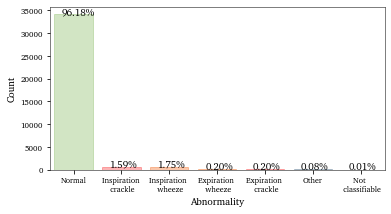

In [8]:
def without_hue(plot, feature, filename):
    total = len(feature)
    
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height() + 5
        ax.annotate(percentage, (x, y), fontproperties = font)
    
    plt.savefig(filename, bbox_inches='tight')
    
    
f, ax = plt.subplots(1,1)
f.set_size_inches(6, 3)
ax = sns.countplot(x = 'label', data = data)
ax.set_ylabel('Count', fontproperties = font)
ax.set_xlabel('Abnormality', fontproperties = font)
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_small)
for label in ax.get_xticklabels() :
    label.set_fontproperties(font_small)
    #name = label.get_text()
    #new_label = str(new_names[name])
    #new_labels.append(new_label)

ax.set_xticklabels(['Normal', 'Inspiration \n crackle', 'Inspiration \n wheeze',
                   'Expiration \n wheeze', 'Expiration \n crackle', 'Other', 'Not \n classifiable'])
#ax.grid(linewidth = 0.3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
count = 0
for child in ax.get_children():
    if type(child) == matplotlib.patches.Rectangle:
        count = count + 1
        
        if (count == 1):
            child.set_color(colors_opa[1])
        elif (count == 2) or (count == 5):
            child.set_color(colors_opa[0])
        elif (count == 3) or (count == 4):
            child.set_color(colors_opa[3])
        elif (count == 6):
            child.set_color(colors_opa[2])
        elif (count == 7):
            child.set_color(colors_opa[5])
        '''
        if (count == 1):
            child.set_color(colors[1])
        elif (count == 2) or (count == 5):
            child.set_color(colors[0])
        elif (count == 3) or (count == 4):
            child.set_color(colors[3])
        elif (count == 6):
            child.set_color(colors[2])
        elif (count == 7):
            child.set_color(colors[5])
        '''
without_hue(ax,data.label , figure_path + "histoLabels.pdf" )  

## Using RMS to compress

In [11]:
file_splits = {
    '/data/ts_files/UiT_15s_TRAIN.ts' : indices_train,
    '/data/ts_files/UiT_15s_TEST.ts' : indices_test,
    '/data/ts_files/UiT_15s_VAL.ts' : indices_val
}

frame_len = round(4000*0.002)
print(f'Frame length for calculating rmf: {frame_len}')
hop_len = ceil(frame_len/1.5)
print(f'Hop length for calculating rmf: {hop_len}')


def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal exp_crackle exp_wheeze insp_crackle insp_wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000
            audio = znorm(audio)
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            #sub_audio = get_sub_audios(audio, frac)
            #for sub in sub_audio: 
                #rms_sub = librosa.feature.rms(sub, frame_length = frame_len, hop_length = hop_len)[0]
                #print(len(rms_sub))
                #if len(rms_sub)> 3350:
                #    print('here')
                #    continue
                #rms_sub = zero_pad(sub, 20000)
                #new_row = str(list(rms_sub))[1:-1].replace(' ', '') + ':' + label + '\n'
                #w.write(new_row)       
            audio = zero_pad(audio, 75000)
            new_row = str(list(audio))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)
            count = count + 1
            print(f'Extracting file : {count}, of totally {len(data)}')    
            
            #break
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
            
'''
frac = 3 --> 5 seconds
frac = 5 --> 3 seconds

'''            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i],3)

Frame length for calculating rmf: 8
Hop length for calculating rmf: 6
Extracting file : 1, of totally 774
Extracting file : 2, of totally 774
Extracting file : 3, of totally 774
Extracting file : 4, of totally 774
Extracting file : 5, of totally 774
Extracting file : 6, of totally 774
Extracting file : 7, of totally 774
Extracting file : 8, of totally 774
Extracting file : 9, of totally 774
Extracting file : 10, of totally 774
Extracting file : 11, of totally 774
Extracting file : 12, of totally 774
Extracting file : 13, of totally 774
Extracting file : 14, of totally 774
Extracting file : 15, of totally 774
Extracting file : 16, of totally 774
Extracting file : 17, of totally 774
Extracting file : 18, of totally 774
Extracting file : 19, of totally 774
Extracting file : 20, of totally 774
Extracting file : 21, of totally 774
Extracting file : 22, of totally 774
Extracting file : 23, of totally 774
Extracting file : 24, of totally 774
Extracting file : 25, of totally 774
Extracting fil

Extracting file : 218, of totally 774
Extracting file : 219, of totally 774
Extracting file : 220, of totally 774
Extracting file : 221, of totally 774
Extracting file : 222, of totally 774
Extracting file : 223, of totally 774
Extracting file : 224, of totally 774
Extracting file : 225, of totally 774
Extracting file : 226, of totally 774
Extracting file : 227, of totally 774
Extracting file : 228, of totally 774
Extracting file : 229, of totally 774
Extracting file : 230, of totally 774
Extracting file : 231, of totally 774
Extracting file : 232, of totally 774
Extracting file : 233, of totally 774
Extracting file : 234, of totally 774
Extracting file : 235, of totally 774
Extracting file : 236, of totally 774
Extracting file : 237, of totally 774
Extracting file : 238, of totally 774
Extracting file : 239, of totally 774
Extracting file : 240, of totally 774
Extracting file : 241, of totally 774
Extracting file : 242, of totally 774
Extracting file : 243, of totally 774
Extracting f

Extracting file : 434, of totally 774
Extracting file : 435, of totally 774
Extracting file : 436, of totally 774
Extracting file : 437, of totally 774
Extracting file : 438, of totally 774
Extracting file : 439, of totally 774
Extracting file : 440, of totally 774
Extracting file : 441, of totally 774
Extracting file : 442, of totally 774
Extracting file : 443, of totally 774
Extracting file : 444, of totally 774
Extracting file : 445, of totally 774
Extracting file : 446, of totally 774
Extracting file : 447, of totally 774
Extracting file : 448, of totally 774
Extracting file : 449, of totally 774
Extracting file : 450, of totally 774
Extracting file : 451, of totally 774
Extracting file : 452, of totally 774
Extracting file : 453, of totally 774
Extracting file : 454, of totally 774
Extracting file : 455, of totally 774
Extracting file : 456, of totally 774
Extracting file : 457, of totally 774
Extracting file : 458, of totally 774
Extracting file : 459, of totally 774
Extracting f

Extracting file : 650, of totally 774
Extracting file : 651, of totally 774
Extracting file : 652, of totally 774
Extracting file : 653, of totally 774
Extracting file : 654, of totally 774
Extracting file : 655, of totally 774
Extracting file : 656, of totally 774
Extracting file : 657, of totally 774
Extracting file : 658, of totally 774
Extracting file : 659, of totally 774
Extracting file : 660, of totally 774
Extracting file : 661, of totally 774
Extracting file : 662, of totally 774
Extracting file : 663, of totally 774
Extracting file : 664, of totally 774
Extracting file : 665, of totally 774
Extracting file : 666, of totally 774
Extracting file : 667, of totally 774
Extracting file : 668, of totally 774
Extracting file : 669, of totally 774
Extracting file : 670, of totally 774
Extracting file : 671, of totally 774
Extracting file : 672, of totally 774
Extracting file : 673, of totally 774
Extracting file : 674, of totally 774
Extracting file : 675, of totally 774
Extracting f

Extracting file : 95, of totally 208
Extracting file : 96, of totally 208
Extracting file : 97, of totally 208
Extracting file : 98, of totally 208
Extracting file : 99, of totally 208
Extracting file : 100, of totally 208
Extracting file : 101, of totally 208
Extracting file : 102, of totally 208
Extracting file : 103, of totally 208
Extracting file : 104, of totally 208
Extracting file : 105, of totally 208
Extracting file : 106, of totally 208
Extracting file : 107, of totally 208
Extracting file : 108, of totally 208
Extracting file : 109, of totally 208
Extracting file : 110, of totally 208
Extracting file : 111, of totally 208
Extracting file : 112, of totally 208
Extracting file : 113, of totally 208
Extracting file : 114, of totally 208
Extracting file : 115, of totally 208
Extracting file : 116, of totally 208
Extracting file : 117, of totally 208
Extracting file : 118, of totally 208
Extracting file : 119, of totally 208
Extracting file : 120, of totally 208
Extracting file :

Extracting file : 107, of totally 260
Extracting file : 108, of totally 260
Extracting file : 109, of totally 260
Extracting file : 110, of totally 260
Extracting file : 111, of totally 260
Extracting file : 112, of totally 260
Extracting file : 113, of totally 260
Extracting file : 114, of totally 260
Extracting file : 115, of totally 260
Extracting file : 116, of totally 260
Extracting file : 117, of totally 260
Extracting file : 118, of totally 260
Extracting file : 119, of totally 260
Extracting file : 120, of totally 260
Extracting file : 121, of totally 260
Extracting file : 122, of totally 260
Extracting file : 123, of totally 260
Extracting file : 124, of totally 260
Extracting file : 125, of totally 260
Extracting file : 126, of totally 260
Extracting file : 127, of totally 260
Extracting file : 128, of totally 260
Extracting file : 129, of totally 260
Extracting file : 130, of totally 260
Extracting file : 131, of totally 260
Extracting file : 132, of totally 260
Extracting f